# **Filtering another sample**

---------------------------

Here we filter the second sample to be used in our data analysis.

----------------
**Execution time: 40 minutes**

------------------------------------

**Import the packages**

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [4]:
sample_3 = sc.read_h5ad('../../Data/notebooks_data/sample_3.h5ad')

We calculate the percentage of mitocondrial genes into each cell. A high percentage denotes the possibility that material from broken cells has been captured during cell isolation, and then sequenced. Mitocondrial percentage is not usually calculated by `scanpy`, because there is need for an identifier for mitocondrial genes, and there is not a standard one. In our case, we look at genes that contain `MT-` into their ID, and calculate their transcript proportion into each cell. We save the result as an observation into `.obs['perc_mito']`

In [5]:
MT = ['MT' in i for i in sample_3.var_names]
perc_mito = np.sum( sample_3[:,MT].X, 1 ) / np.sum( sample_3.X, 1 )
sample_3.obs['perc_mito'] = perc_mito.copy()

## Visualize and evaluate quality measures

We can do some plots to have a look at quality measures combined together

**Counts vs Genes:** this is a typical plot, where you look at the total transcripts per cells (x axis) and detected genes per cell (y axis). Usually, those two measures grow together. Points with a lot of transcripts and genes might be multiplets (multiple cells sequenced together as one), while very few transcripts and genes denote the presence of only ambient RNA or very low quality sequencing of a cell. Below, the dots are coloured based on the percentage of mitocondrial transcripts. Note how a high proportion is often on cells with very low transcripts and genes (bottom left corner of the plot)

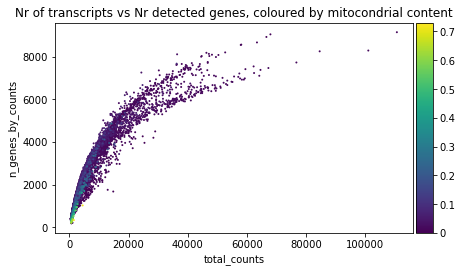

In [6]:
sc.pl.scatter(sample_3, x='total_counts', y='n_genes_by_counts', color='perc_mito', 
              title ='Nr of transcripts vs Nr detected genes, coloured by mitocondrial content')

**Transcripts and Genes distribution:** Here we simply look at the distribution of transcripts per cells and detected genes per cell. Note how the distribution is bimodal. This usually denotes a cluster of low-quality cells and viable cells. Sometimes filtering out the data points on the left-most modes of those graphs removes a lot of cells from a dataset, but this is quite a normal thing not to be worried about. The right side of the distributions show a tail with few cells having a lot of transcripts and genes. It is also good to filter out some of those extreme values - for technical reasons, it will also help in having a better normalization of the data later on.

Text(0.5, 1.0, 'Cells Transcripts distribution')

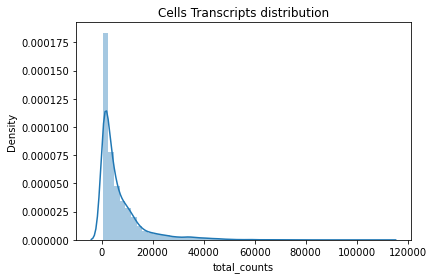

In [7]:
ax = sns.distplot(sample_3.obs['total_counts'], bins=50)
ax.set_title('Cells Transcripts distribution')

Text(0.5, 1.0, 'Distribution of detected genes per cell')

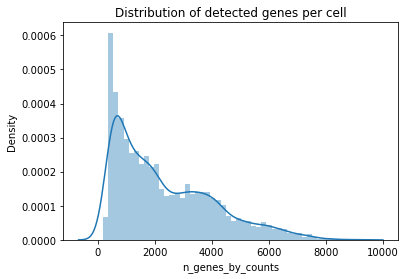

In [8]:
ax = sns.distplot(sample_3.obs['n_genes_by_counts'], bins=50)
ax.set_title('Distribution of detected genes per cell')

In this dataset there are few cell with a high percentage of mitocondrial content. Those are precisely 245 if we set 0.1 (that is 10%) as a treshold. A value between 10% and 20% is the usual standard when filtering single cell datasets.

In [9]:
#subsetting to see how many cells have percentage of mitocondrial genes above 10%
sample_3[ sample_3.obs['perc_mito']>0.1, : ].shape

(474, 36601)

Text(0.5, 1.0, 'Distribution of mitocondrial content per cell')

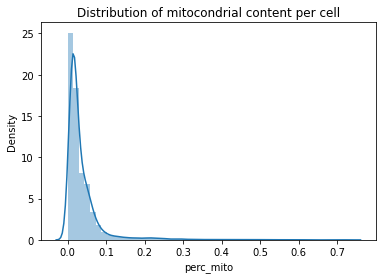

In [10]:
ax = sns.distplot(sample_3.obs['perc_mito'], bins=50)
ax.set_title('Distribution of mitocondrial content per cell')

## Choosing thresholds

Let's establish some filtering values by looking at the plots above.

In [11]:
MIN_COUNTS = 5000   #minimum number of transcripts per cell
MAX_COUNTS = 40000  #maximum number of transcripts per cell
MIN_GENES = 2000    #minimum number of genes per cell
MAX_GENES = 6000    #maximum number of genes per cell
MAX_MITO = .1       #mitocondrial percentage treshold

We can do some subsetting to zoom into the plots we did before

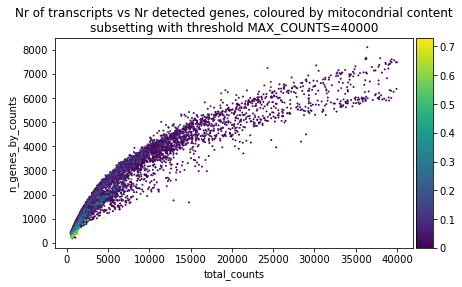

In [12]:
sc.pl.scatter(sample_3[ sample_3.obs['total_counts']<MAX_COUNTS ], 
              x='total_counts', y='n_genes_by_counts', color='perc_mito',
              title =f'Nr of transcripts vs Nr detected genes, coloured by mitocondrial content\nsubsetting with threshold MAX_COUNTS={MAX_COUNTS}')

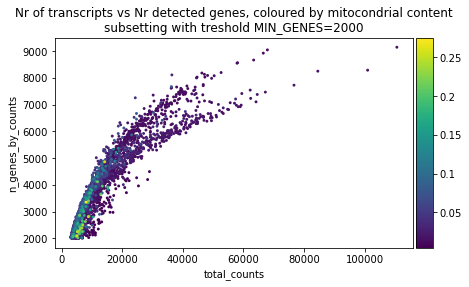

In [13]:
sc.pl.scatter(sample_3[ sample_3.obs['n_genes_by_counts'] > MIN_GENES ], 
              x='total_counts', y='n_genes_by_counts', color='perc_mito',
              title =f'Nr of transcripts vs Nr detected genes, coloured by mitocondrial content\nsubsetting with treshold MIN_GENES={MIN_GENES}')

The following commands filter using the chose tresholds. Again, scanpy does not do the mitocondrial QC filtering, so we do that on our own by subsetting the data. 

Note for the last two filterings: the parameter `min_cells` remove all those cells showing transcripts for only 10 genes or less - standard values for this parameter are usually between 3 and 10, and do not come from looking at the QC plots. The last command uses the standard value for the mitocondrial content treshold.

In [14]:
sc.preprocessing.filter_cells(sample_3, max_counts=MAX_COUNTS)

sc.preprocessing.filter_cells(sample_3, min_counts=MIN_COUNTS)

sc.preprocessing.filter_cells(sample_3, min_genes=MIN_GENES)

sc.preprocessing.filter_cells(sample_3, max_genes=MAX_GENES)

sc.preprocessing.filter_genes(sample_3, min_cells=10)

sample_3 = sample_3[sample_3.obs['perc_mito']<MAX_MITO].copy()

We have been reducing the data quite a lot from the original >8000 cells. Often, even more aggressive filterings are done. For example, one could have set the `MIN_GENES` parameter to 3000. It would have been anyway in the area between the two modes of the QC plot.

In [15]:
sample_3

AnnData object with n_obs × n_vars = 2690 × 23454
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'umi_raw'

## Doublet filtering

Another important step consists in filtering out multiplets. Those are in the almost totality of the cases doublets, because triplets and above multiplets are extremely rare. Read [this more technical blog post](https://liorpachter.wordpress.com/2019/02/07/sub-poisson-loading-for-single-cell-rna-seq/) for more explanations about this.

The external tool `scrublet` simulates doublets by putting together the transcripts of random pairs of cells from the dataset. Then it assigns a score to each cell in the data, based on the similarity with the simulated doublets. An `expected_doublet_rate` of 0.06 (6%) is quite a typical value for single cell data, but if you have a better estimate from laboratory work, microscope imaging or a specific protocol/sequencing machine, you can also tweak the value. 
`random_state` is a number choosing how the simulations are done. using a specific random state means that you will always simulate the same doublets whenever you run this code. This allows you to reproduce exactly the same results every time and is a great thing for reproducibility in your own research.

In [16]:
 sc.external.pp.scrublet(sample_3, 
                        expected_doublet_rate=0.06,
                        random_state=12345)

Automatically set threshold at doublet score = 0.31
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 55.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.2%


It seems that the doublet rate is likely to be lower than 6%, meaning that in this regard the data has been produced pretty well. We now plot the doublet scores assigned to each cell by the algorithm. We can see that most cells have a low score (the score is a value between 0 and 1). Datasets with many doublets show a more bimodal distribution, while here we just have a light tail beyond 0.1. 

<AxesSubplot:xlabel='doublet_score', ylabel='Density'>

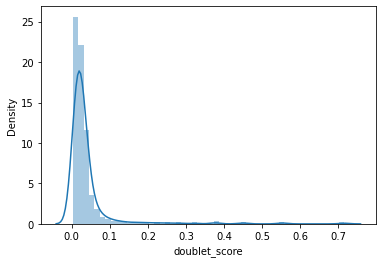

In [17]:
sns.distplot(sample_3.obs['doublet_score'])

We can choose 0.1 as filtering treshold for the few detected doublets or alternatively use the automatic selection of doublets by the algorithm. We will choose the last option and use the automatically chosen doublets.

In [18]:
sample_3 = sample_3[np.invert(sample_3.obs['predicted_doublet'])].copy()

## Evaluation of filtering

A quite basic but easy way to look at the results of our filtering is to normalize and plot the dataset on some projections. Here we use a standard normalization technique that consists of:
- **TPM normalization**: the transcripts of each cell are normalized, so that their total amounts to the same value. This should make cells more comparable independently of how many transcripts their has been retained during cell isolation.
- **Logarithmization**: the logarithm of the normalized transcripts is calculated. This reduce the variability of transcripts values and highlights variations due to biological factors.
- **Standardization**: Each gene is standardized across all cells. This is useful for example  for projecting the data onto a PCA. 

In [21]:
# TPM normalization and storage of the matrix
sc.pp.normalize_per_cell(sample_3)
sample_3.layers['umi_tpm'] = sample_3.X.copy()

# Logarithmization and storage
sc.pp.log1p(sample_3)
sample_3.layers['umi_log'] = sample_3.X.copy()

# Select some of the most meaningful genes to calculate the PCA plot later
# This must be done on logarithmized values
sc.pp.highly_variable_genes(sample_3, n_top_genes=15000)

# save the dataset
sample_3.write('../../Data/notebooks_data/sample_3.filt.h5ad')

# standardization and matrix storage
sc.pp.scale(sample_3)
sample_3.layers['umi_gauss'] = sample_3.X.copy()

Now we calculate the PCA projection

In [22]:
sc.preprocessing.pca(sample_3, svd_solver='arpack', random_state=12345)

We can look at the PCA plot and color it by some quality measure and gene expression. We can already see how the PCA has a clear structure with only a few dots sparsed around. It seems the filtering has got a good result.

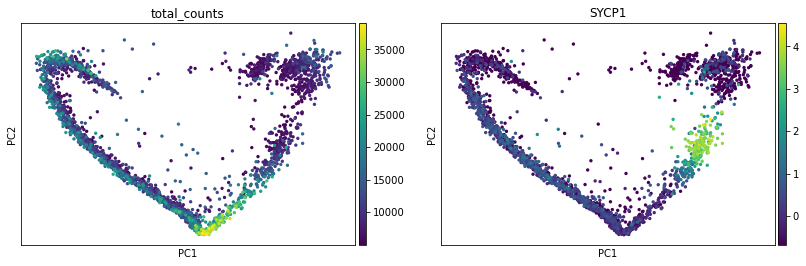

In [23]:
sc.pl.pca(sample_3, color=['total_counts','SYCP1'])

We plot the variance ratio to see how each component of the PCA changes in variability. Small changes in variability denote that the components are mostly modeling noise in the data. We can choose a threshold (for example 15 PCA components) to be used in all algorithms that use PCA to calculate any quantity.

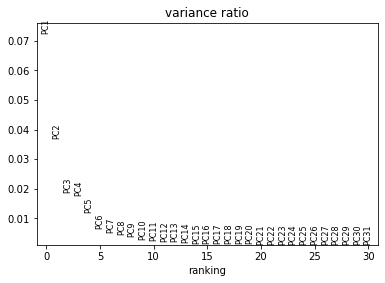

In [24]:
sc.plotting.pca_variance_ratio(sample_3)

We project the data using the UMAP algorithm. This is very good in preserving the structure of a dataset in low dimension, if any is present. We first calculate the neighbors of each cell (that is, its most similar cells), those are then used for the UMAP. The neighbors are calculated using the PCA matrix instead of the full data matrix, so we can choose the number of PCA components to use (parameter `n_pcs`). Many algorithms work on the PCA, so you will see the parameter used again in other places.

In [25]:
sc.pp.neighbors(sample_3, n_pcs=15, random_state=12345)

In [ ]:
sc.tools.umap(sample_3, random_state=54321)

The UMAP plot gives a pretty well-structured output for this dataset. We will keep working further with this filtering.

In [ ]:
sc.plotting.umap(sample_3, color=['total_counts','SYCP1'])